# L12b: Develop a Multiclass Artificial Neural Network Image Classifier

___

In this lab, students will develop a [Feed-Forward Neural Network (FNN)](https://en.wikipedia.org/wiki/Feedforward_neural_network) that will classify images of handwritten numbers between `0,...,9` taken from the [Modified National Institute of Standards and Technology (MNIST) database](https://en.wikipedia.org/wiki/MNIST_database). Each digit between `0` and `9` has approximately 5000 example images, each of which is a `28`$\times$`28` grayscale image; thus, each image has `784` pixels.  

* _Objective_: We'll train a _deep_ feedforward neural network to classify images of handwritten digits. The FNN will be a _multiclass classifier_, i.e., it will classify images into one of `10` classes, each corresponding to a digit between `0` and `9`.
* _Implementation_: Toward this task, we'll use the [Flux.jl package](https://github.com/FluxML/Flux.jl) to build, train, and test our image classifier. However, there are two excellent libraries for ANNs in Python (sort of), namely the [PyTorch library](https://pytorch.org/) from the [AI group at META](https://ai.meta.com/meta-ai/) and the [TensorFlow library](https://www.tensorflow.org/) developed by [Google](https://research.google/). 

## Tasks
Before we start, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!
* __Task 1: Setup, Data, Prerequisites (5 min)__: Let's take 5 minutes to load [the MNIST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database) that our feed-forward network will model. We've seen this data before, so we won't spend much time reviewing it.
* __Task 2: Setup the model structure and training (30 min)__: In this task, we'll construct and train a feedforward model, i.e., we'll learn the model parameters, using example images encoded in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}`. The training will use the [Gradient Descent with momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) algorithm to minimize the logit cross-entropy loss function. There is some new content here, so we'll spend a few minutes going over this material.
* __Task 3: How well does the model predict unseen versus observed images (10 min)?__: In this task, we'll check the network's generalization, i.e., how well it does on data it has not seen, by computing the number of correct predictions on the test set. 

Let's get started!

___

## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl")

In [4]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end];

### Load the MNIST digits data set
Before training and testing the `FFN,` we need to construct two datasets. First, we build a `training dataset` of images that we will use to estimate the model parameters. We'll save training data in the `training_image_dataset` variable. Next, we'll construct a `test dataset,` which we'll use to see how well our `FFN` generalizes (predicts) data it has never seen. We'll save this data in the `testing_image_dataset` variable.
* Both the `training_image_dataset` and `testing_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x,` i.e., the pixels of the image arranged in vector format. The second element is the `label,` i.e., whether the image corresponds to `0,....,9`.
* The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of weird features. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot ecoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

Before we load the training data, let's set some constants, which we use below. The comment next to each constant describes its permissible values, units, etc.

In [148]:
number_of_training_examples = 3000; # TODO: specify how many training examples of *each* number to include from the library
number_of_test_examples = 500; # TODO: Specify how many examples are we going to test on?
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?

#### Select a set of `training` images and build the `training_image_dataset.`
`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. 
* We load `number_of_training_examples::Int` images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}` and then convert these to a vector vector format, i.e.., linearize the `28`$\times$`28` matrix of `Gray` values into a vector of `784` pixels.

In [150]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
    for i ∈ number_digit_array
        
        # create a set for this digit -
        image_digit_array = Array{Gray{N0f8},3}(undef, number_of_rows, number_of_cols, number_of_training_examples);
        files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
        imagecount = 1;
        for fileindex ∈ 1:number_of_training_examples
            filename = files[fileindex];
            ext = file_extension(filename)
            if (ext == "jpg")
                image_digit_array[:,:,fileindex] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
                imagecount += 1
            end
        end
    
        # capture -
        training_image_dictionary[i] = image_digit_array
    end
    training_image_dictionary
end;

What's in the `training_image_dictionary` variable?

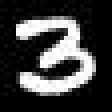

In [196]:
# Let's make sure we understand what is going on here ...
training_image_dictionary[3][:,:,2999] # how does the indexing work?

__Vectorize the training images__.
* _What do we mean by vectorize_? Each $N\times{N}$ image array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* _What's the deal with Float32_? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory space because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/), which has different memory constraints.

In [154]:
training_image_dataset = let
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = training_image_dictionary[i];
        
        for t ∈ 1:number_of_training_examples
            D = Array{Float32,1}(undef, number_of_pixels);
            linearindex = 1;
            for row ∈ 1:number_of_rows
                for col ∈ 1:number_of_cols
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            training_tuple = (D,Y);
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset
end;

What's in the `training_image_dataset` variable?

In [212]:
training_image_dataset[1000][2] # how does the indexing work here?

10-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅

#### Select a set of `test` images and build the `testing_image_dataset`
`Unhide` the code blocks below to see how we construct and populate the `testing_image_dataset` variable.
* We load `number_of_test_examples::Int` images into the `testing_image_dataset::Dict{Int64, Array{Gray{N0f8},3}}` and then convert these to a vector vector format, i.e.., linearize the `28`$\times$`28` matrix of `Gray` values into a vector of `784` pixels.

In [158]:
testing_image_dictionary = let
    testing_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
    for i ∈ number_digit_array
        
        # create a set for this digit -
        image_digit_array = Array{Gray{N0f8},3}(undef, number_of_rows, number_of_cols, number_of_test_examples);
        files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
        imagecount = 1;
        for fileindex ∈ (number_of_training_examples + 1):(number_of_training_examples+number_of_test_examples)
            filename = files[fileindex];
            ext = file_extension(filename)
            if (ext == "jpg")
                image_digit_array[:,:,imagecount] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
                imagecount += 1
            end
        end
    
        # capture -
        testing_image_dictionary[i] = image_digit_array
    end

    testing_image_dictionary # return
end

Dict{Int64, Array{Gray{N0f8}, 3}} with 10 entries:
  0 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray…
  4 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray…
  5 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.02) Gray{N0f8}(0.016); G…
  6 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray…
  2 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray…
  7 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray…
  9 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray…
  8 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray…
  3 => [Gray{N0f8}(0.0) Gray{N0f8}(0.004) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gr…
  1 => [Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray…

__Vectorize the testing images__. 

In [160]:
testing_image_dataset = let
    testing_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = testing_image_dictionary[i];
        
        for t ∈ 1:number_of_test_examples
            D = Array{Float32,1}(undef, number_of_pixels);
            linearindex = 1;
            for row ∈ 1:number_of_rows
                for col ∈ 1:number_of_cols
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            testing_tuple = (D,Y);
            push!(testing_image_dataset, testing_tuple);
        end
    end

    testing_image_dataset
end;

In [214]:
length(testing_image_dataset)

5000

## Task 2: Setup the model structure and training
In this task, we'll construct and train a feedforward model, i.e., learn the model parameters, using example images encoded in the the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}`. 
* _Hmmm_. This is an example of _supervised batch learning_, i.e., the model learns its parameters on a fixed set of labeled examples. However, unlike an _online_ learning approach, e.g., the perceptron, there is no update rule. Thus, new data cannot be easily included (once we have the parameters, we have them).

Let's start by getting the `number_of_input_states::Int64`; this will be the input dimension of the first layer in our model:

In [162]:
number_of_input_states = length(training_image_dataset[1][1])

784

Then, we build an empty model with default (random) parameter values but a fixed structure. The number and dimension of the layers and the activation functions for each layer are specified when we build the model (but we'll update the parameters during training).
* _Library_: We use [the `Flux.jl` machine learning library](https://github.com/FluxML/Flux.jl) to construct the neural network model. The model will have three layers: the input layer is a `784` $\times$ `512` layer with [relu activation functions](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), the hidden layer is a `512` $\times$ `10` layer and the output layer is the [softmax function](https://en.wikipedia.org/wiki/Softmax_function).
* _Syntax_: The [`Flux.jl` package](https://github.com/FluxML/Flux.jl) uses some next level syntax. The model is built using [the `Chain` function](https://fluxml.ai/Flux.jl/stable/reference/models/layers/#Flux.Chain), which takes a list of layers as input. Each layer is defined using the [`Dense` type](https://fluxml.ai/Flux.jl/stable/reference/models/layers/#Flux.Dense) (in this case), which takes the number of input and output neurons as arguments. The activation function is an additional argument to [the `Dense` type](https://fluxml.ai/Flux.jl/stable/reference/models/layers/#Flux.Dense). The final layer uses [the `softmax(...)` method exported by the `NNlib.jl` package](https://fluxml.ai/NNlib.jl/dev/reference/#Softmax) to produce a probability distribution over the classes.

In [220]:
# TODO: Uncomment the code below to build the model!
Flux.@layer MyFluxNeuralNetworkModel; # create a "namespaced" of sorts
MyModel() = MyFluxNeuralNetworkModel( # a strange type of constructor
    Chain(
        Dense(number_of_input_states, 512, relu),  # layer 1
        Dense(512, 10, relu), # layer 2
        NNlib.softmax) # layer 3 (output layer)
);
model = MyModel().chain;

__Loss function__: Next, specify the `loss` function we will minimize to estimate the model parameters. We choose a loss function that is appropriate for a _multiclass classification problem_, namely a [logit cross-entropy loss function](https://fluxml.ai/Flux.jl/stable/reference/models/losses/#Flux.Losses.logitcrossentropy):
$$
\mathcal{L}(\theta) = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C} y_{ij}\log(p_{ij}(\theta))
$$
where the outer summation is over all $N$ training examples, and the inner summation is over the $C$ possible classes. The $y_{ij}$ is the one-hot encoded label for the $i$th training example, and $p_{ij}$ is the predicted probability of the $i$th training example being in class $j$. 

In [242]:
# TODO: Uncomment below to setup the loss function -
loss(ŷ, y) = Flux.Losses.logitcrossentropy(ŷ, y; agg = mean); # loss for training multiclass classifiers, what is the agg?

We'll use [Gradient descent with momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) where the `λ` parameter denotes the `learning rate` and `β` denotes the momentum parameter. We save information about the optimizer in the `opt_state` variable, which will eventually get passed to the training method.
* _Why_? We could have chosen one of _many_ possible training approaches. The [`Flux.jl` library supports _many_ optimizers](https://fluxml.ai/Flux.jl/stable/reference/training/optimisers/#Optimisers-Reference) which are all some version of gradient descent. However, there is no _technical_ reason we couldn't have chosen an optimizer that doesn't rely on computing the gradient of the loss function. For example, we could have used a genetic algorithm or other optimization method. However, these methods are _likely_ not as efficient as gradient descent for this problem.
* __DQ__: Brainstorm with your neighbor about how we would figure out the _best_ value for the `λ` and `β` hyperparameters.

In [246]:
λ = 0.01; # learning rate (default: 0.01)
β = 0.90; # momentum parameter (default: 0.90)
opt_state = Flux.setup(Momentum(λ, β), model);

We are now ready to train the model. If the `should_we_train = true,` then we use the [Gradient descent with momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) to minimize a [logit cross-entropy loss function](https://fluxml.ai/Flux.jl/stable/reference/models/losses/#Flux.Losses.logitcrossentropy).
* _Restart_: Because the error landscape is non-convex, we have to start from many different locations. We do `number_of_epochs` passes through the data, i.e., a forward pass for prediction and a backpropagation step for parameter updates. Although the training is a little opaque, intuition suggests that the library is choosing different initial parameter guesses for each pass through the data and then driving these to convergence.
* _Training takes a long time_. For each complete pass through the data, i.e., for each `epoch,` we save a `tmp` file holding the network state... just in case of `BOOOOOOOOM.`  We also have some pre-trained models to load if the `should_we_train` flag is false.

In [ ]:
should_we_train = true; # TODO: set this flag to {true | false}
if (should_we_train == true)
    number_of_epochs = 250; # how many epochs do we want to train for?
    for i = 1:number_of_epochs
        
        # train the model -
        Flux.train!(model, training_image_dataset, opt_state) do m, x, y
            loss(m(x), y)
        end
    
        # output some stuff -
        ridx = rand(1:number_of_training_examples);
        test_x, test_y = training_image_dataset[ridx][1], training_image_dataset[ridx][2];
        l = loss(model(test_x), test_y);
        println("Training example: $(ridx) has loss = $(l) in epoch $(i)");
    
        # save the state of the model, in case something happens. We can reload from this state
        jldsave("tmp-model-training-checkpoint.jld2", model_state = Flux.state(model))    
    end
else
    # if we don't train: load up a previous model
    model_state = JLD2.load("model-state-T3000-P500-E250-N512.jld2", "model_state");
    Flux.loadmodel!(model, model_state);
end

Training example: 727 has loss = 1.46115 in epoch 1
Training example: 1189 has loss = 1.46115 in epoch 2
Training example: 1158 has loss = 1.46115 in epoch 3
Training example: 835 has loss = 1.46115 in epoch 4
Training example: 1205 has loss = 1.46115 in epoch 5
Training example: 1924 has loss = 1.46115 in epoch 6
Training example: 2156 has loss = 1.46115 in epoch 7
Training example: 445 has loss = 1.46115 in epoch 8
Training example: 1198 has loss = 1.46115 in epoch 9
Training example: 542 has loss = 1.46115 in epoch 10
Training example: 2883 has loss = 1.46115 in epoch 11
Training example: 1688 has loss = 1.46115 in epoch 12
Training example: 1201 has loss = 1.46115 in epoch 13
Training example: 1491 has loss = 1.46115 in epoch 14
Training example: 1095 has loss = 1.46115 in epoch 15
Training example: 2471 has loss = 1.46115 in epoch 16
Training example: 29 has loss = 1.46115 in epoch 17
Training example: 1107 has loss = 1.46115 in epoch 18
Training example: 2400 has loss = 1.46115 i

## Task 3: How well does the model predict unseen versus observed images?
In this task, we'll check the network's generalization, i.e., how well it does on data it has not seen. One of the challenges with [Neural Networks)](https://en.wikipedia.org/wiki/Neural_network_(machine_learning)) is the lack of generalizability, i.e., they _may not_ perform well on data the model has not seen. 

Let's explore this question:
* First, compute the fraction of the `training data` that is correctly classified. This will help us understand how many of the `N` training samples we get correct and how many we get wrong. We expect to be _mostly correct_ on the training data.
* Next, we'll do the same thing but with the `test data,` i.e., data the model has never seen. We expect the correct prediction fraction on the test data to be less than or, at best, equal to the equivalent training data value.

### Correct prediction `training` dataset
In the code block below, we pass the pixel data from the image into the `model` instance, compute the predicted label `ŷ,` and compare the predicted and actual labels for the `training` dataset.
* _Logic_: If the prediction and the actual label agree, we update the `S` variable (a running count of the number of correct predictions). Finally, we compute the fraction of _correct_ classifications by dividing the number of correct predictions by the total number of images in the `training` dataset.

In [251]:
S_training = 0;
for i ∈ eachindex(training_image_dataset)
    
    x = training_image_dataset[i][1];
    y = training_image_dataset[i][2];
    ŷ = model(x) |> z-> argmax(z) |> z-> number_digit_array[z] |> z-> onehot(z,number_digit_array)
    y == ŷ ? S_training +=1 : nothing
end
correct_prediction_training = (S_training/length(training_image_dataset))*100;
println("Correct prediction % on the training data: $(correct_prediction_training)%");

Correct prediction % on the training data: 89.92999999999999%


### Correct prediction `test` dataset
In the code block below, we pass the pixel data from the image into the `model` instance, compute the predicted label `ŷ,` and compare the predicted and actual label for the `test` dataset. 
* _Logic_: If the prediction and the actual label agree, we update the `S` variable (a running count of the number of correct predictions). Finally, we compute the fraction of _correct_ classifications by dividing the number of correct predictions by the total number of images in the `test` dataset.

In [253]:
S_testing = 0;
for i ∈ eachindex(testing_image_dataset)
    
    x = testing_image_dataset[i][1];
    y = testing_image_dataset[i][2];
    ŷ = model(x) |> z-> argmax(z) |> z-> number_digit_array[z] |> z-> onehot(z, number_digit_array)
    y == ŷ ? S_testing+=1 : nothing
end
correct_prediction_test = (S_testing/length(testing_image_dataset))*100;
println("Correct prediction on the test data: $(correct_prediction_test)%");

Correct prediction on the test data: 89.64%


#### Examples
Let's do a few manual examples, and see what we get. 

* In the code block below, we take a few _random_ images from the `testing_image_dataset` and compare the predicted and actual labels (in one-hot format). If the _prediction is wrong_, we print the actual image and the predicted label.

Bool[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


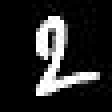

In [302]:
let
    
    N = length(testing_image_dataset); # how many test examples
    i = rand(1:N) # select a random test example
    x = testing_image_dataset[i][1]; # get the input for this test example
    y = testing_image_dataset[i][2]; # get the *actual* output for this test example (onehot encoding)
   
    # compute onehot encoding of the predicted output -
    ŷ = model(x) |> z-> argmax(z) |> z-> number_digit_array[z] |> z-> onehot(z, number_digit_array)
    flag = y == ŷ # check that the predicted output is the same as the actual output
    if (flag == false)
        println(ŷ) # onehot encoding of the *predicted* output
        display(reshape(x, number_of_rows, number_of_cols) |> X -> Gray.(transpose(X))); # actual image
    end
end

## Next time
In lecture `L12c` we will continue our discussion of artificial neural networks, and then move on to a discussion of [Recurrent Neural Networks (RNNs)](https://en.wikipedia.org/wiki/Recurrent_neural_network). 

* In partciular, we'll discuss basic `RNN` architectures, and how these systems can be used to model data sequences. We will also discuss the [Long Short Term Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) architecture (in `L12d`), which is a special case of an `RNN` that is particularly well suited for modeling time series data.